<a href="https://colab.research.google.com/github/jmestanza/Guia_2_PASA/blob/master/Guia_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
! wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/originales/kickpush.wav"
clear_output()

import warnings
warnings.filterwarnings("ignore")
from scipy.io.wavfile import read
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import wave, struct, math, random
from IPython.display import Audio
from scipy.linalg import toeplitz
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import ccf


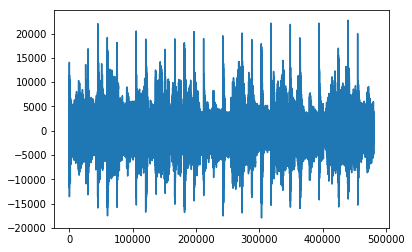

In [0]:
def fast_plot(data):
    plt.plot(range(len(data)),data)
def normalize(datos):
    return np.interp(datos, (datos.min(), datos.max()), (-1, +1)) #normalizamos
def get_mono_array(stereo_file_name):
    file = read(stereo_file_name)
    fs = file[0]
    datos = np.array(file[1],dtype=float) 
    if len(np.shape(datos))>1: #si tiene dos canales
        ch0 = datos[:, 0]
        ch1 = datos[:, 1]
        datos = (ch0 + ch1)/2  # o lo hacemos mono
    return fs, datos

#Ejemplo para obtener un numpy array mono a partir de un archivo stereo
file_name = "kickpush.wav" 
fs, data = get_mono_array(file_name)
plt.plot(range(len(data)),data)


In [0]:
Audio(data,rate=fs)

In [0]:
# Ahora empieza el TP
# Obtenemos los datos de sweep lento
! wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/originales/sweep_lento.wav"
! wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/grabados/grab_sweep_lento.wav"
clear_output()

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

file_name = "grab_sweep_lento.wav"  
fs, grab_sw_lento = get_mono_array(file_name)
grab_sw_lento = grab_sw_lento[int(1.2*fs):len(grab_sw_lento)-int(0.5*fs)]
grab_sw_lento = grab_sw_lento - np.mean(grab_sw_lento)
grab_sw_lento = normalize(grab_sw_lento)

file_name = "sweep_lento.wav"  
fs, sw_lento = get_mono_array(file_name)
sw_lento = sw_lento[:len(sw_lento)-int(0.5*fs)]
sw_lento = sw_lento - np.mean(sw_lento)
sw_lento = normalize(sw_lento)


In [0]:
# Esta es la grabación
Audio(grab_sw_lento,rate=fs)

In [0]:
# Este es el audio original
Audio(sw_lento,rate=fs)

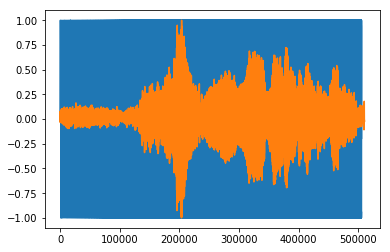

In [0]:
plt.plot(range(len(sw_lento)),sw_lento)
plt.plot(range(len(grab_sw_lento)),grab_sw_lento)

In [0]:
# hago que tengan la misma longitud
grab_sw_lento = grab_sw_lento[:500000]
sw_lento = sw_lento[:500000]

los grupos estan divididos en  9600.0 ticks


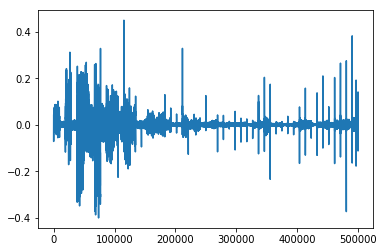

In [131]:
# Ahora hacemos las cuentas para estimar el filtro óptimo
section_time = 200e-3
section_time_ticks = section_time*fs
print("los grupos estan divididos en ", section_time_ticks, "ticks")
grupos = int(len(grab_sw_lento) //section_time_ticks)

secciones_grabadas = np.array_split(grab_sw_lento,grupos)
secciones_originales = np.array_split(sw_lento,grupos)

LAGS = 10
fragmentos_estimados = []
for i in range(grupos):
# r i in range(1):
  # rxx = np.var(secciones_grabadas[i])*acf(secciones_grabadas[i], nlags =LAGS)
    N = len(secciones_grabadas[i])
    rxx = autocorr(secciones_grabadas[i])/N #esta autocorr ya esta centrada
    rxx = rxx[0:LAGS+1]
    # p es la correlacion cruzada de u(n) y d(n)
    p = np.correlate(secciones_grabadas[i],secciones_originales[i],'full')/N
    mitad_de_p = len(p)//2
    p = p[mitad_de_p-(LAGS): (mitad_de_p+1)] # +1 porque quiero que incluya mitad de p
    # mitad_de_p-LAGS hace que me de un arreglo de cantidad LAGS+1, como rxx
    p = np.flip(p) # estaban ordenados p(-2), p(-1), p(0) asi que flipeo
    #p = ccf(secciones_grabadas[i],secciones_originales[i])
    R = toeplitz(rxx)
    # resuelve el sistema R wo = p
    wo = np.linalg.solve(R, p)
    wo = np.roll(wo, LAGS+1)
    estimado = np.convolve(secciones_grabadas[i],wo,'same')
    fragmentos_estimados += list(estimado)
fast_plot(fragmentos_estimados)
Audio(fragmentos_estimados,rate=fs)
